## map2loop: Code mess to estimate unit thickness, nowhere near working

#### Need to ignore points across faults, fold hinges. 
#### Now need to get points from neighbouring strat unit intersections, 
#### rotate around orig by dipdir, to get // to Y-axis then sort wrt Y and calc apparent_thickness = dist between points,
#### then true thickness by apparent_thickness*sin(DIP)

In [1]:
import os
from IPython.core.display import display, HTML
print(os.getcwd())
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


In [2]:
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import os
import rasterio
from rasterio.transform import from_origin
from rasterio import features
%matplotlib inline
import sys, os
sys.path.insert(0,"../..")
print(os.getcwd())
#rootdir=r'C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2model\\'
#os.chdir(rootdir)
print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


In [3]:
mname='hams2' #root name of model input data

print(os.getcwd())
newdir='../test_data2'
print(newdir)
os.chdir(newdir)


text=False    #display debug text
graphics=True #display debug images


model_base=-8200 # top could be found using highest point in topo data

minlong=117
maxlong=118
minlat=-23
maxlat=-22

minx=500057    #left hams
maxx=603028    #right
miny=7455348   #bottom
maxy=7567953   #top
    

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found

src_crs = 'epsg:2346'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

# 'epsg:28350'  =  GDA_1994_MGA_Zone_50 
# 'epsg:4326'   =   wgs84 GEODETIC LAT/LONG 

orientation_decimate=0   # decimation of orientaiton data (0 = no decimation)
contact_decimate=30   # decimation of contact data (0 = no decimation)

gcode='GROUP_'
dcode='DIP'
ddcode='DIP_DIR'
ccode='CODE'


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks
../test_data2


## Load geology map

In [4]:
# Extract point data from WAROX & geology map for gempy
##First we readin the WAROX and map from shapefiles, or wherever...

import geopandas as gpd
import os
from shapely.geometry import Polygon
from shapely.geometry import Point


%matplotlib inline
os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


geology = gpd.read_file('./tmp/geol_clip.shp')
print(geology.crs)


{'init': 'epsg:28350'}


## Basic explode code

In [5]:
#https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26
    
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(indf):
#    indf = gpd.GeoDataFrame.from_file(indata)
    outdf = gpd.GeoDataFrame(columns=indf.columns)
    for idx, row in indf.iterrows():
        if type(row.geometry) == Polygon:
            outdf = outdf.append(row,ignore_index=True)
        if type(row.geometry) == MultiPolygon:
            multdf = gpd.GeoDataFrame(columns=indf.columns)
            recs = len(row.geometry)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom,'geometry'] = row.geometry[geom]
            outdf = outdf.append(multdf,ignore_index=True)
    return outdf

## Load topological sorted surfaces

In [6]:
ag=open('./tmp/'+mname+'_all_sorts.csv',"r")
contents =ag.readlines()
ag.close

ulist=[]
for i in range(1,len(contents)):
    cont_list=contents[i].split(",")
    ulist.append([i, cont_list[4].replace("\n","")])
print(ulist)


[[1, 'P__WYa_st'], [2, 'P__WYm_sp'], [3, 'P__WYd_kd'], [4, 'P__SKq_stq'], [5, 'P__SKb_bb'], [6, 'P__TK_s'], [7, 'P__TKa_xs_k'], [8, 'P__TKo_stq'], [9, 'P__TKk_sf'], [10, 'P__HAo_ci'], [11, 'P__HAw_fr'], [12, 'P__HAj_xci_od'], [13, 'P__HAb_cib'], [14, 'A_HAS_xsl_ci'], [15, 'A_HAd_kd'], [16, 'A_HAm_cib'], [17, 'A_FOj_xs_b'], [18, 'A_FOu_bbo'], [19, 'A_FOp_bs'], [20, 'A_FOo_bbo'], [21, 'A_FOh_xs_f'], [22, 'A_FOr_b'], [23, 'A_s_PMI'], [24, 'A_s_PRK'], [25, 'A_b_PRK']]


## Load all basal contact points

In [7]:
import math
def angle(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    inner_product = x1*x2 + y1*y2
    len1 = math.hypot(x1, y1)
    len2 = math.hypot(x2, y2)
    dot=math.degrees(math.acos(inner_product/(len1*len2)))
    return 90-math.fabs(90-dot)

def pairs(lst):
    for i in range(1, len(lst)):
        yield lst[i-1], lst[i]

        #https://www.geeksforgeeks.org/program-check-three-points-collinear/

# Python program to check 
# if three points are collinear 
# or not using area of triangle. 
  
# function to check if  
# point collinear or not 
def collinear(x1, y1, x2, y2, x3, y3): 
      
    """ Calculation the area of   
        triangle. We have skipped  
        multiplication with 0.5 to 
        avoid floating point computations """
    a = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2) 
    b=x1 * (y2 - y3)
    c=x2 * (y3 - y1)
    d=x3 * (y1 - y2) 
  
    #if (a < 0.000001): 
    #    print ("Yes",a,b,c,d)
    #else: 
    #    print ("No",a,b,c,d)
    return(a< 0.000001)
  
# This code is contributed 
# by Sachin Bisht 

import rasterio

dataset = rasterio.open('./dtm\\'+mname+'_dtm_rp.tif')

def height_from_srtm(x,y):
    locations=[(x,y)]
    for val in dataset.sample(locations):
        return(str(val).replace("[","").replace("]",""))


## Create basal contact points with orientation from orientations and basal points

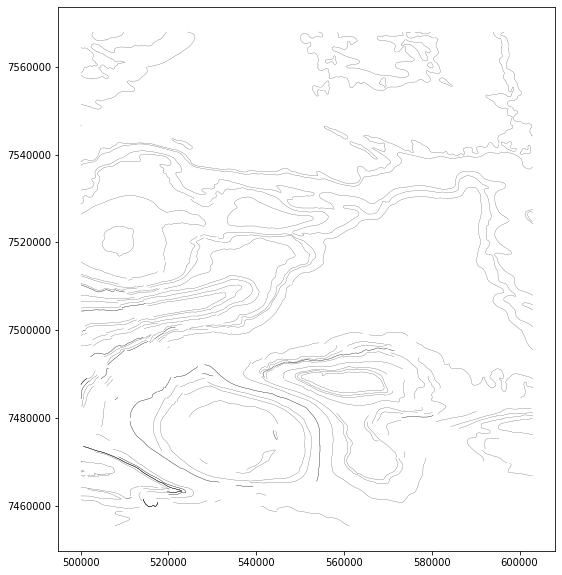

In [8]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import MultiPoint,Point,LineString
from shapely.ops import nearest_points
import math

contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

warox = gpd.read_file('./tmp/structure_clip.shp') #load orientation data as geopandas dataframe 

contacts.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2)

In [9]:
f=open('./output/'+mname+'_projected_dip_contacts2.csv',"w")
f.write('id,x,y,z,DIP,DIP_DIR,polarity,CODE,GROUP_\n')
#print("len=",len(contacts))
i=0
for acontact in contacts.iterrows():   #loop through distinct linestrings
    #display(acontact[1].geometry)
    thegroup=acontact[1]['GROUP_']
    #print("thegroup=",thegroup)
    is_wrx=warox['GROUP_'] == thegroup # subset orientations to just those with this group
    all_wrx = warox[is_wrx]

    for awrx in all_wrx.iterrows(): # loop through valid orientations
        #print(awrx[1].geometry,awrx[1]['GROUP_'])
        orig = Point(awrx[1]['geometry'])
        nearp = acontact[1].geometry.interpolate(acontact[1].geometry.project(orig))
        if(nearp.distance(orig)<5000):
            #print(acontact[1]['CODE'],awrx[1]['DIP'],orig,np)                  
            for line in acontact[1].geometry: # loop through line segments
                for pair in pairs(list(line.coords)): # loop through line segments
                    segpair=LineString((pair[0],pair[1]))
                    if segpair.distance(nearp)< 0.0001: # line segment closest to close point
                        ddx=math.sin(math.radians(awrx[1]['DIP_DIR']))
                        ddy=math.cos(math.radians(awrx[1]['DIP_DIR']))
                        dlsx=pair[0][0]-pair[1][0]
                        dlsy=pair[0][1]-pair[1][1]
                        lsx=dlsx/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        lsy=dlsy/math.sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        angle=math.degrees(math.acos((ddx*lsx)+(ddy*lsy)))
                        #print(i,angle,ls_ddir,lsx,lsy,awrx[1]['DIP_DIR'])
                        if(math.fabs(angle-90)<30.0): # dip_dir normal and contact are close enough to parallel
                            height= height_from_srtm(nearp.x,nearp.y)
                            ls_ddir=math.degrees(math.atan2(lsy,-lsx)) #normal to line segment
                            #print(i,ddx,ddy,lsx,lsy,ls_ddir,awrx[1]['DIP_DIR'])
                           
                            if (ddx*lsy)+(-ddy*lsx)<0: #dot product tests right quadrant
                                ls_ddir=(ls_ddir-180)%360
                            ostr=str(i)+","+str(nearp.x)+","+str(nearp.y)+","+height+","+str(awrx[1]['DIP'])+","+str(ls_ddir)+",1,"+acontact[1]['CODE']+","+acontact[1]['GROUP_']+"\n" 
                            f.write(ostr)
                            i=i+1


f.close()

## Populate all contacts as orientations

In [91]:
#maybe just bite bullet and do all contact/dip estimates, then from lower unit project to upper (if not found or outside range ignore), could be easier.

#loop through basal surfaces
    #for every decimated point
        #find closest structure point(s)
            #calc dip direction, estimate dips
from shapely.prepared import prep

dist_buffer=10000            
structure = gpd.read_file('./tmp/structure_clip.shp') #load orientation data as geopandas dataframe 
contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

f=open('./tmp/'+mname+'_all_contact_dips.csv',"w")
f.write('x,y,ave_dip\n')


all_sorts=pd.read_csv('./tmp/'+mname+'_all_sorts.csv')
#display(all_sorts)
#display(structure)
prep_structures=prep(structure)

for a_contact in contacts.iterrows(): # loop through basal contacts
    if(a_contact[1].geometry.type=='LineString'): #loop through LineStrings
        for pair in pairs(list(a_contact)):
            n_dip=0
            sum_dip=0
            for a_struct in structure.iterrows():
                #print(a_struct[1])
                l_point= Point((pair[1].geometry.coords[0][0],pair[1].geometry.coords[0][1]))
                s_point= Point((a_struct[1].geometry.coords[0][0],a_struct[1].geometry.coords[0][1]))
                l_buf=l_point.buffer(dist_buffer)
                prepared_polygon = prep(l_buf)
                hits = filter(prepared_polygon.contains, points)

                if(s_point.distance(l_point)<dist_buffer):
                    sum_dip=sum_dip+a_struct[1][dcode]
                    n_dip=n_dip+1
            if(n_dip>0):
                ave_dip=sum_dip/n_dip
                #print(pair[1].geometry.coords[0][0],",",pair[1].geometry.coords[0][1],",",ave_dip)
                ostr=str(pair[1].geometry.coords[0][0])+","+str(pair[1].geometry.coords[0][1])+","+str(ave_dip)+"\n"
                f.write(ostr)
            else:
                #print("none_found")
                continue
              
    else:  #loop through MultiLineStrings
        for a_line in a_contact[1].geometry:
            for pair in pairs(list(a_line.coords)):
                n_dip=0
                sum_dip=0
                for a_struct in structure.iterrows():
                    #print(a_struct[1])
                    l_point= Point((pair[0][0],pair[0][1]))
                    s_point= Point((a_struct[1].geometry.coords[0][0],a_struct[1].geometry.coords[0][1]))
                    #print(l_point,s_point)
                    if(s_point.distance(l_point)<dist_buffer):
                        sum_dip=sum_dip+a_struct[1][dcode]
                        n_dip=n_dip+1
                if(n_dip>0):
                    ave_dip=sum_dip/n_dip
                    #print(pair[0][0],pair[0][1],",",ave_dip)
                    ostr=str(pair[0][0])+","+str(pair[0][1])+","+str(ave_dip)+"\n"
                    f.write(ostr)
                else:
                    #print("none_found",pair[0][0],",",pair[0][1])
                    continue
f.close()

## Estimate layer thicknesses

In [31]:
structure = gpd.read_file('./tmp/structure_clip.shp') #load orientation data as geopandas dataframe 
contacts = gpd.read_file('./tmp/basal_contacts2.shp') #load orientation data as geopandas dataframe 

f=open('./output/'+mname+'_estimated_layer_thicknesses.csv',"w")
f.write('index,position,x,y\n')

all_sorts=pd.read_csv('./tmp/'+mname+'_all_sorts.csv')
#display(all_sorts)
#display(structure)
#print("id,x,y,code,group")
for apair in all_sorts.iterrows():
    for bpair in all_sorts.iterrows():
        i=0
        if(int(apair[1]['index'])==(int(bpair[1]['index'])+1) and apair[1]['group']==bpair[1]['group'] ):
            #print("--------",apair[1]['index'],bpair[1]['index'],apair[1]['group'],bpair[1]['group'])
            #print(structure['GROUP_'].replace("-","_").replace(" ","_"),apair[1]['group'])
            is_struct=structure['GROUP_'] == apair[1]['group'].replace("_"," ") # subset orientations to just those with this group
            all_struct = structure[is_struct]      
            is_contacta=contacts['CODE'] == apair[1]['code'].replace("__","_-") # subset contacts to just those with a code
            acontacts = contacts[is_contacta]
            
            is_contactb=contacts['CODE'] == bpair[1]['code'].replace("__","_-") # subset contacts to just those with b code
            bcontacts = contacts[is_contactb]
            #print(all_struct.shape,acontacts.shape,bcontacts.shape)
            
            crossings=np.zeros((1000,5))
            
            for a_struct in all_struct.iterrows(): # loop through valid orientations
                #print(a_struct[1]['geometry'].x,a_struct[1]['geometry'].y)
                dx1=math.sin(math.radians(a_struct[1]['DIP_DIR']))*1e5
                dy1=math.cos(math.radians(a_struct[1]['DIP_DIR']))*1e5
                dx2=-dx1
                dy2=-dy1
                p1=Point((dx1+a_struct[1]['geometry'].x,dy1+a_struct[1]['geometry'].y))
                p2=Point((dx2+a_struct[1]['geometry'].x,dy2+a_struct[1]['geometry'].y))
                ddline=LineString((p1,p2))
                orig = Point(a_struct[1]['geometry'])

                for acontact in acontacts.iterrows():   #loop through distinct linestrings for upper contact
                    #print(acontact[1]['CODE'],apair[1]['code'])
                    #break
                    if(ddline.intersects(acontact[1].geometry)): 
                        isects=ddline.intersection(acontact[1].geometry)
                        #print(type(isects),isects)
                        if(isects.geom_type=="MultiPoint"):
                            for pt in isects: 
                                if(pt.distance(orig)<21000):
                                    #print(i,",", pt.x, ",",pt.y,",",apair[1]['code'],",",apair[1]['group'])
                                    crossings[i,0]=i
                                    crossings[i,1]=int(apair[1]['index'])
                                    crossings[i,2]=0
                                    crossings[i,3]=pt.x
                                    crossings[i,4]=pt.y
                                    i=i+1
                        else:
                            if(isects.distance(orig)<2000):
                                #print(i,",", isects.x,",", isects.y,",",apair[1]['code'],",",apair[1]['group'])
                                crossings[i,0]=i
                                crossings[i,1]=int(apair[1]['index'])
                                crossings[i,2]=0
                                crossings[i,3]=pt.x
                                crossings[i,4]=pt.y
                                i=i+1
                
                for bcontact in bcontacts.iterrows():   #loop through distinct linestrings for lower contact
                    #break
                    if(ddline.intersects(bcontact[1].geometry)): 
                        isects=ddline.intersection(bcontact[1].geometry)
                        if(isects.geom_type=="MultiPoint"):
                            for pt in isects: 
                                if(pt.distance(orig)<15000):
                                    #print(i,",", pt.x, ",",pt.y,",",bpair[1]['code'],",",bpair[1]['group'])
                                    crossings[i,0]=i
                                    crossings[i,1]=int(apair[1]['index'])
                                    crossings[i,2]=1
                                    crossings[i,3]=pt.x
                                    crossings[i,4]=pt.y
                                    i=i+1
                        else:
                            if(isects.distance(orig)<15000):
                                #print(i,",", isects.x,",", isects.y,",",bpair[1]['code'],",",bpair[1]['group'])
                                crossings[i,0]=i
                                crossings[i,1]=int(apair[1]['index'])
                                crossings[i,2]=1
                                crossings[i,3]=pt.x
                                crossings[i,4]=pt.y
                                i=i+1
            #print('\n',apair[1]['code'].replace("__","_-"),bpair[1]['code'].replace("__","_-"))
            for j in range(0,i):
                ostr=str(crossings[j,1])+","+str(crossings[j,2])+","+str(crossings[j,3])+","+str(crossings[j,4])+"\n"
                f.write(ostr)
                #print(crossings[j,0],crossings[j,1],crossings[j,2],crossings[j,3],crossings[j,4])
            #if(i==0):
              #  print("@@@@@@@@@@@@@@@@@@@@@@@@@@@ No contact pair for",apair[1]['code'],bpair[1]['code'])
            #else:
                #print("@@@@@@@@@@@@@@@@@@@@@@@@@@@",i+1," contact pairs for",apair[1]['code'],bpair[1]['code'])
f.close()

In [11]:
# Need to ignore points across faults. 
# Now need to get points from neighbouring strat unit intersections, 
# rotate around orig by dipdir, to get // to Y-axis then sort wrt Y and calc apparent_thickness = dist between points,
# then true thickness by apparent_thickness*sin(DIP)